<a href="https://colab.research.google.com/github/Sugoto/Human-Activity-Recognition/blob/main/HAR_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HAR using LSTM model with Convolution**

#### Mount Google Drive if the dataset has been uploaded

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#### Importing necessary libraries

In [ ]:
import os
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, ConvLSTM2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold


#### Loading and preprocessing data

In [ ]:
def load_file(filepath):
    data = read_csv(filepath, header=None, delim_whitespace=True, dtype=np.float32)
    return data.values


def load_group(filenames, prefix=''):
    loaded = [load_file(os.path.join(prefix, name)) for name in filenames]
    return np.dstack(loaded)


def load_dataset_group(group, prefix=''):
    filepath = os.path.join(prefix, group, 'Inertial Signals')
    filenames = [
        f'total_acc_x_{group}.txt',
        f'total_acc_y_{group}.txt',
        f'total_acc_z_{group}.txt',
        f'body_acc_x_{group}.txt',
        f'body_acc_y_{group}.txt',
        f'body_acc_z_{group}.txt',
        f'body_gyro_x_{group}.txt',
        f'body_gyro_y_{group}.txt',
        f'body_gyro_z_{group}.txt'
    ]

    X = load_group(filenames, filepath)
    y = load_file(os.path.join(prefix, group, f'y_{group}.txt'))
    y = y - 1
    y = to_categorical(y)

    return X, y


def load_dataset(prefix=''):
    train_X, train_y = load_dataset_group('train', os.path.join(prefix, '/content/drive/MyDrive/Colab Notebooks/Datasets/HAR_UCI'))
    test_X, test_y = load_dataset_group('test', os.path.join(prefix, '/content/drive/MyDrive/Colab Notebooks/Datasets/HAR_UCI'))

    return train_X, train_y, test_X, test_y


#### Training and evaluating the LSTM model 

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    n_steps, n_length = 4, 32
    trainX = trainX.reshape(
        (trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

    early_stop = EarlyStopping(
        monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(
        1, 3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])

    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,
                        verbose=verbose, validation_data=(testX, testy), callbacks=[early_stop])

    _, accuracy = model.evaluate(
        testX, testy, batch_size=batch_size, verbose=0)

    return accuracy, history


#### Running and summarizing results of a training pass using K-Fold Cross Validation

Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping
Pass 1, Fold 1: 96.467
Pass 1, Fold 2: 95.380
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Pass 1, Fold 3: 94.558
Restoring model weights from the end of the best epoch: 18.
Epoch 23: early stopping
Pass 1, Fold 4: 95.646
Pass 1, Fold 5: 96.327
Pass 1, Fold 6: 96.599
Restoring model weights from the end of the best epoch: 15.
Epoch 20: early stopping
Pass 1, Fold 7: 96.463
Pass 1, Fold 8: 95.782
Pass 1, Fold 9: 97.415
Pass 1, Fold 10: 95.374


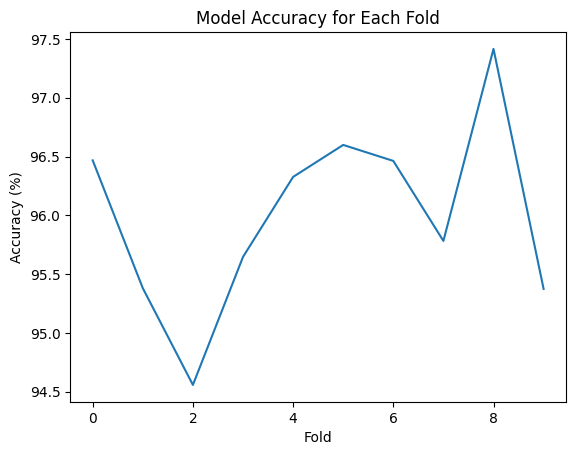


Mean Accuracy: 96.001% (+/-0.000)


In [ ]:
def summarize_results(scores):
    mean_scores = np.mean(scores, axis=0)
    std_scores = np.std(scores, axis=0)
    plt.plot(mean_scores)
    plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.1)
    plt.title('Model Accuracy for Each Fold')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Fold')
    plt.show()

    print(f'\nMean Accuracy: {np.mean(mean_scores):.3f}% (+/-{np.mean(std_scores):.3f})')


def run_experiment(repeats=1):
    train_X, train_y, test_X, test_y = load_dataset()
    all_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for r in range(repeats):
        fold_scores = []
        for i, (train_idx, val_idx) in enumerate(kf.split(train_X), 1):
            X_train, X_val = train_X[train_idx], train_X[val_idx]
            y_train, y_val = train_y[train_idx], train_y[val_idx]

            score = evaluate_model(X_train, y_train, X_val, y_val)[0] * 100.0
            fold_scores.append(score)
            print(f'Pass {r+1}, Fold {i}: {score:.3f}')

        all_scores.append(fold_scores)

    summarize_results(all_scores)


run_experiment()
